<a href="https://colab.research.google.com/github/harshy105/Uni_luebeck/blob/main/ML_exercise_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 4: Boosting

**Note**: Please insert the names of all participating students:

1. 
2. 
3. 
4. 
5. 

## Exercise 4.1: 

In this exercise, we will use the adaptive boosting algorithm [AdaBoost](https://en.wikipedia.org/wiki/AdaBoost) to combine multiple weak classification models to one strong classifier for a two-class classification problem
on a two-dimensional dataset. Our simple classifier will be a threshold on either dimension, dividing the dataset into two classes.
The data will be generated with the provided function genData. Each row in the generated matrix data corresponds to one observation and each column to a single feature. The generated vector labels contains the corresponding desired output value of the two-class classification problem. 

When done correctly, your code should do the following:
1. Create a random dataset.
2. Iterativly, do the following:
    <br>a) Train another weak classification model.
    <br>b) Compute the predictions of the weak classifier.
    <br>c) Calculate the weighted training error of the weak classifier.
    <br>d) Update the distribution of weights assigned to each data sample.
    <br>e) Combine all the weak classification models to one strong classifier.
    <br>f) Calculate the error of the strong classifier.
    <br>g) Compute the decision boundary of the strong classifier.
3. Plot the error of the strong classifier for each iteration.
4. Create an animation which shows how the decision boundary of the strong classifiers changes over time.

In case you are struggeling with the task, here are some helpful tips and hints:
1. Useful functions : gen_data, train_classifier, get_decision_boundary
2. Good initial values are: n_samples=2000, n_classifiers=200.


In [ ]:
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%matplotlib inline

def gen_data(n_samples):
    """
    Generate data.
    
    INPUT:
        n_samples : number of samples to generate (observations)
        
    OUTPUT:
       data : 2D data points
       labels : ndarray of class labels with integer values -1 or 1
    """
    
    data = np.random.random((n_samples,2)) - 0.5
    labels = np.linalg.norm(data, axis=1) < 0.4
    labels = (labels.astype(int) * 2) - 1
    
    return data, labels

class Classifier(object):
    
    def __init__(self, dimension=0, threshold=0., sign=1):
        super().__init__()
        self.dimension = dimension
        self.threshold = threshold
        self.sign = sign
        
    def predict(self, data):
        """
        Predict new data

        INPUT:
            data : 2D data points

        OUTPUT:
            estimated labels
        """
        return self.sign * ((data[:, self.dimension] >= self.threshold).astype(int) * 2 - 1)
    
def train_classifier(classifier, data, targets, weights):
    """
    Predict new data

    INPUT:
        classifier : classifier to train
        data : 2D data points
        targets : ndarray of class labels with integer values -1 or 1
        weights: weights assigned to each data sample

    OUTPUT:
        classifier : trained classifier
    """
    min_error = np.inf
    dimensions = [0, 1]
    thresholds = np.linspace(-0.5, 0.5, 11)
    signs = [-1, 1]
    best_parameters = (0, 0., 1)

    for d in dimensions:
        classifier.dimension = d
        for t in thresholds:
            classifier.threshold = t
            for s in signs:
                classifier.sign = s
                
                predictions = classifier.predict(data)
                error = (weights * (predictions != targets).astype(int)).sum()
                
                if error < min_error:
                    best_parameters = (d, t, s)
                    min_error = error
    
    classifier.dimension = best_parameters[0]
    classifier.threshold = best_parameters[1]
    classifier.sign = best_parameters[2]
    return classifier

class Animation(object):
    """
    Creates animation object to visualize the decision boundaries of the strong classifier.
    """
    def __init__(self, data, labels, decision_boundaries):
        """
        INPUT:
            data : 2D data points
            labels : ndarray of class labels with integer values -1 or 1
            decision_boundaries: ndarray of shape (n_classifiers, n**2) with prediction results for an (n x n) grid.
        """
        super().__init__()
        self.decision_boundaries = decision_boundaries
        
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # plot data points
        ax.scatter(data[labels==-1,1], data[labels==-1,0], c=np.array([[0.5, 0.7, 1.]]), marker='o')
        ax.scatter(data[labels==1,1], data[labels==1,0], c=np.array([[1., 0.6, 0.6]]), marker='x')
        # write axis labels
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        
        x_lim = ax.get_xlim()
        y_lim = ax.get_ylim()
        im = ax.imshow(decision_boundaries[0], extent=(-0.55,0.55,-0.55,0.55), interpolation='none', cmap='jet', origin='lower', vmin=-1, vmax=1)
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        
        fig.colorbar(im)
        
        self.fig = fig
        self.im = im
        
    def animate(self, i):
        """
        animate function for FuncAnimation
        
        Input:
            i : integer for indexing
        """
        self.im.set_array(self.decision_boundaries[i])
        
    def get_animation(self):
        """
        Return animation object which holds the animation
        """
        return FuncAnimation(self.fig, self.animate, frames=len(self.decision_boundaries))

def get_decision_boundary(data, classifiers, alphas):
    """
    Create the decision boundary of a strong classifier. The function creates a 12 x 12 grid and a strong classifier. For every location in the grid the prediction is obtained and returned.
    
    INPUT:
        data : 2D data points
        classifiers : list of trained classifiers
        alphas : ndarray with weights of the classifiers

    OUTPUT:
        decision_boundary : ndarray of shape (n_classifiers, 12**2) with prediction results for a (12 x 12) grid.
    """
    
    n_classifiers = len(classifiers)
    
    # create grid
    nx = 12
    ny = 12
    x = np.linspace(-0.5, 0.5, nx)
    y = np.linspace(-0.5, 0.5, ny)
    xx, yy = np.meshgrid(x, y)
    xy = np.stack((xx.reshape(-1),yy.reshape(-1)), 1)
    
    # classify grid points
    predictions = np.zeros((ny * nx, n_classifiers))
    for i, classifier in enumerate(classifiers):
        prediction = classifier.predict(xy)
        predictions[:,i] = prediction
    decision_boundary = ((alphas[None,:n_classifiers] * predictions).sum(axis=1) > 0).astype(int) * 2 - 1
    decision_boundary = decision_boundary.reshape(ny, nx)
    
    return decision_boundary

In [ ]:
"""
Choose hyperparameters
"""
# TODO set number of samples (observations)
n_samples = 2000

# TODO set number of rounds
n_classifiers = 80

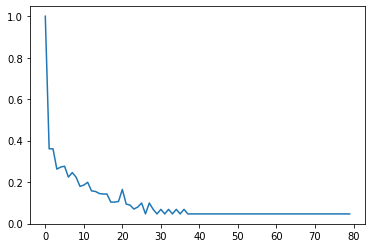

In [ ]:
"""
Train, combine, and visualize multiple weak classifiers 
"""

# TODO generate data
data, targets = gen_data(n_samples)

# TODO initialize sample weights
weights = np.ones((n_samples))/n_samples

# TODO initialize arrays or lists for storing the alphas, predictions, decision_boundaries, errors and classifiers
all_alphas = np.zeros(n_samples)
all_errors = np.zeros(n_classifiers)
all_weak_prediction = []
all_trained_classifiers = []
all_decision_boundaries = []

for t in range(n_classifiers):
    # TODO train weak classifier
    classifier = Classifier()
    trained_classifier = train_classifier(classifier,data,targets,weights)
    all_trained_classifiers.append(trained_classifier)
    
    # TODO compute predictions of the weak classifier
    prediction_weak = trained_classifier.predict(data)
    all_weak_prediction.append(prediction_weak)
    
    # TODO calculate the weighted! training error of the weak classifier
    weighted_sum_error = (weights[prediction_weak != targets]).sum()
    #train_error = (prediction_weak != targets).sum()

    # TODO calculate alpha
    all_alphas[t] = 0.5*np.log((1-weighted_sum_error)/weighted_sum_error) 

    # TODO update weight distribution for samples (note: normalization)
    weights = weights*np.exp(-all_alphas[t]*targets*prediction_weak)
    weights = weights/weights.sum() # normalisation

    # TODO calculate the error of the final strong classifier (so far)
    prediction_strong = 0
    for i in range(t):
      prediction_strong = prediction_strong + all_alphas[i]*all_weak_prediction[i]

    prediction_strong = np.sign(prediction_strong)

    #print(prediction_strong)  
    all_errors[t] = sum(prediction_strong!=targets)/n_samples
    #print(all_errors[t])

    # TODO compute the decision boundary of the current strong classifier (so far) 
    decision_boundary = get_decision_boundary(data,all_trained_classifiers,all_alphas)
    all_decision_boundaries.append(decision_boundary)
    
# TODO plot the error of the final strong classifiers for each round
plt.plot(all_errors)
plt.show()



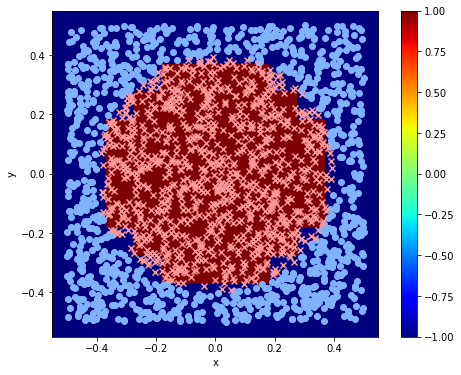

In [ ]:
animation = Animation(data, targets, all_decision_boundaries)
HTML(animation.get_animation().to_jshtml())

## Exercise 3.2: Comprehension Questions

Answer the following comprehension questions either with right or wrong and briefly explain your decision:

1. The margin of a Support Vector Machine (SVM) is the distance of the nearest data point to the separating hyperplane.

True

2. The support vectors are the data samples furthest away from the seperating hyperplane of a SVM.

False, they are the nearest ones to the Hyperplane

3. All support vectors have the same distance to the seperating hyperplane.

Your answer:

4. To maximize the margin in an SVM, you minimize the length of the weight vector (under the given constraints).

Your answer:

5. Slack variables are introduced to allow for misclassification in a SVM.

Your answer:

6. The parameter C in the optimization of a SVM (c.f. equation 2.30) controls the tradeoff between maximization of the margin and minimizing the number of misclassified samples.

Your answer:

7. A small parameter C could lead to overfitting.

Your answer:

8. A SVM with the kernel $K \left( \vec{x}, \vec{y} \right) = \langle \vec{x}, \vec{y}\rangle^2$ can be used to separate the data given in task 1 (hint: see exercise 2).

Your answer:

9. To seperate 5 different classes with a multi-class SVM, in total you need to train 5 SVM for one-versus-all and 9 SVM for one-versus-one.

Your answer: